In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk import PorterStemmer

from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report




In [51]:
data = pd.read_csv("Coronavirus Tweets (1).csv",encoding='latin-1')
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


### Text Preprocessing

#### Removing any emojis

In [52]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [53]:
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x: remove_emoji(x))

In [54]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


#### Remove URLs

In [55]:
def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

In [56]:
data['OriginalTweet'] = np.vectorize(remove_URL)(data['OriginalTweet'])
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv and and,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


#### Replace Contractions

In [57]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#### Removing @usernames

In [58]:
def remove_pattern(text,pattern):
    r = re.findall(pattern,text)
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [59]:
data['OriginalTweet'] = np.vectorize(remove_pattern)(data['OriginalTweet'], "@[\w]*")
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,and and,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


#### Lowering Text

In [60]:
data['OriginalTweet']= data['OriginalTweet'].apply(lambda x: x.lower())
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,and and,2
1,3800,48752,UK,16-03-2020,advice talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia: woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,my food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"me, ready to go at supermarket during the #cov...",0


#### Replace Numbers

In [61]:
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [62]:
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x: replace_numbers(x))
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,"[ , , , , a, n, d, , , a, n, d, ]",2
1,3800,48752,UK,16-03-2020,"[a, d, v, i, c, e, , t, a, l, k, , t, o, , ...",1
2,3801,48753,Vagabonds,16-03-2020,"[c, o, r, o, n, a, v, i, r, u, s, , a, u, s, ...",1
3,3802,48754,NaN,16-03-2020,"[m, y, , f, o, o, d, , s, t, o, c, k, , i, ...",1
4,3803,48755,NaN,16-03-2020,"[m, e, ,, , r, e, a, d, y, , t, o, , g, o, ...",0


#### Punctuation Removal

In [63]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [64]:
data['OriginalTweet'] = np.vectorize(remove_punctuation)(data['OriginalTweet'])
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,and and,2
1,3800,48752,UK,16-03-2020,advice talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths to give elder...,1
3,3802,48754,NaN,16-03-2020,my food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,me ready to go at supermarket during the covid...,0


#### Removing Stopwords

In [65]:
stop_words = set(stopwords.words('english'))

In [66]:
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    # converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    #with no lower case conversion
    filtered_sentence = []
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

In [67]:
data['OriginalTweet']= data['OriginalTweet'].apply(lambda x:remove_stopwords(x))

In [68]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,[],2
1,3800,48752,UK,16-03-2020,"[advice, talk, neighbours, family, exchange, p...",1
2,3801,48753,Vagabonds,16-03-2020,"[coronavirus, australia, woolworths, give, eld...",1
3,3802,48754,NaN,16-03-2020,"[food, stock, one, empty, please, dont, panic,...",1
4,3803,48755,NaN,16-03-2020,"[ready, go, supermarket, covidonenine, outbrea...",0


#### Removing row in which OriginalTweet length is 0

In [69]:
data.drop(data[data["OriginalTweet"].apply(lambda x : len(x) == 0)].index, inplace=True)

In [157]:
data.reset_index(inplace=True)

In [70]:
data[data["OriginalTweet"].apply(lambda x : len(x) == 0)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


### Text Normalization

#### Stemming

Making words to sentences

In [71]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [72]:
data['OriginalTweet_Stemming']= data['OriginalTweet'].apply(lambda x:stem_words(x))

In [73]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_Stemming
1,3800,48752,UK,16-03-2020,"[advice, talk, neighbours, family, exchange, p...",1,"[adv, talk, neighbo, famy, exchang, phon, numb..."
2,3801,48753,Vagabonds,16-03-2020,"[coronavirus, australia, woolworths, give, eld...",1,"[coronavir, austral, woolworth, giv, eld, dis,..."
3,3802,48754,NaN,16-03-2020,"[food, stock, one, empty, please, dont, panic,...",1,"[food, stock, on, empty, pleas, dont, pan, eno..."
4,3803,48755,NaN,16-03-2020,"[ready, go, supermarket, covidonenine, outbrea...",0,"[ready, go, supermarket, covidonenin, outbreak..."
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"[news, regionâs, first, confirmed, covidoneni...",1,"[new, regionâs, first, confirm, covidonenin, ..."


#### Lemmatization

In [74]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [75]:
data['OriginalTweet_Lemmatizating']= data['OriginalTweet'].apply(lambda x:lemmatize_verbs(x))
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_Stemming,OriginalTweet_Lemmatizating
1,3800,48752,UK,16-03-2020,"[advice, talk, neighbours, family, exchange, p...",1,"[adv, talk, neighbo, famy, exchang, phon, numb...","[advice, talk, neighbour, family, exchange, ph..."
2,3801,48753,Vagabonds,16-03-2020,"[coronavirus, australia, woolworths, give, eld...",1,"[coronavir, austral, woolworth, giv, eld, dis,...","[coronavirus, australia, woolworths, give, eld..."
3,3802,48754,NaN,16-03-2020,"[food, stock, one, empty, please, dont, panic,...",1,"[food, stock, on, empty, pleas, dont, pan, eno...","[food, stock, one, empty, please, dont, panic,..."
4,3803,48755,NaN,16-03-2020,"[ready, go, supermarket, covidonenine, outbrea...",0,"[ready, go, supermarket, covidonenin, outbreak...","[ready, go, supermarket, covidonenine, outbrea..."
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"[news, regionâs, first, confirmed, covidoneni...",1,"[new, regionâs, first, confirm, covidonenin, ...","[news, regionâs, first, confirm, covidonenine..."


#### Stemming and Lemmatization




* Stemming - It is the process of reducing infected words to their stem.Stemming with replace words “history” and “historical” with “histori”. Similarly, for the words finally and final.

* Lemmatization - In stemming, for some words, it may not give may not give meaningful representation such as “Histori”. Here, lemmatization comes into picture as it gives meaningful word.Lemmatization takes more time as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time.


- Why? choose Stemming over Lemmatization?
    - Lemmatization uses a corpus to attain a lemma, making it slower than stemming. Further, to get the proper lemma, you might have to define a parts-of-speech. Whereas, in stemming a step-wise algorithm is followed making it faster.
    - Stemming has its application in Sentiment Analysis while Lemmatization has its application in Chatbots, human-answering.


In [76]:
data.drop(columns=["OriginalTweet_Lemmatizating"], inplace=True)

### tokens back together and Stemming

In [77]:
def concatination_tokens(tokenized_tweet):
    return ' '.join(tokenized_tweet)

data["OriginalTweet_Stemming"] = data["OriginalTweet_Stemming"].apply(lambda x : concatination_tokens(x))
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_Stemming
1,3800,48752,UK,16-03-2020,"[advice, talk, neighbours, family, exchange, p...",1,adv talk neighbo famy exchang phon numb cre co...
2,3801,48753,Vagabonds,16-03-2020,"[coronavirus, australia, woolworths, give, eld...",1,coronavir austral woolworth giv eld dis ded sh...
3,3802,48754,NaN,16-03-2020,"[food, stock, one, empty, please, dont, panic,...",1,food stock on empty pleas dont pan enough food...
4,3803,48755,NaN,16-03-2020,"[ready, go, supermarket, covidonenine, outbrea...",0,ready go supermarket covidonenin outbreak im p...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"[news, regionâs, first, confirmed, covidoneni...",1,new regionâs first confirm covidonenin cas ca...


In [78]:
data.shape

(41130, 7)

### word cloud

In [79]:
all_words_positive = ' '.join(text for text in data['OriginalTweet_Stemming'])

In [80]:
len(set(all_words_positive.split(" ")))

39463

In [81]:
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_positive)


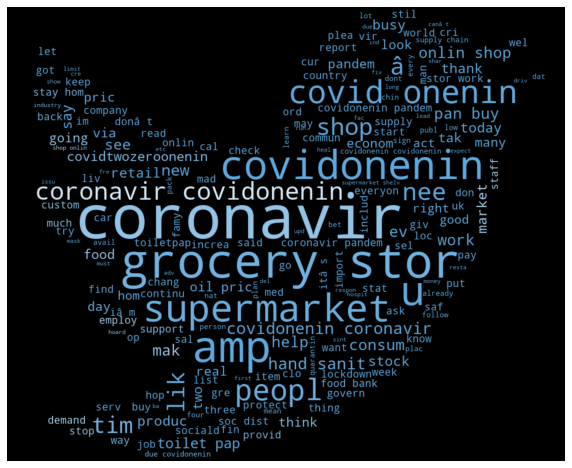

In [82]:
# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

### Models Creation

BOW and Decision Tree

In [174]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(data['OriginalTweet_Stemming'])
bow

<41130x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 545612 stored elements in Compressed Sparse Row format>

In [175]:
df_bow = pd.DataFrame(bow.todense())

df_bow

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
x_train_bow, x_test_bow, y_train_bow, y_test_bow = train_test_split(df_bow,data['Sentiment'],test_size=0.2,random_state=2)

In [181]:
dct = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth= 200)
dct.fit(x_train_bow,y_train_bow)

DecisionTreeClassifier(criterion='entropy', max_depth=200, random_state=1)

In [182]:
print(dct.tree_.max_depth)

200


-  trying to hyperparamter tune the decision tree

In [183]:
# max_depth_dt = pd.DataFrame(columns=["Depth","Score_train", "score_test"])
# for max_d in range(1, 500, 10):
#   model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
#   model.fit(x_train_bow, y_train_bow)
# #   print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(x_train_bow, y_train_bow))
# #   print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(x_test_bow,y_test_bow))
#   max_depth_dt[max_d] = [max_d, model.score(x_train_bow, y_train_bow), model.score(x_test_bow,y_test_bow)]
#   print('')
# max_depth_dt

In [184]:
dct_bow = dct.predict_proba(x_test_bow)

dct_bow


array([[0.17757009, 0.1105919 , 0.71183801],
       [0.17757009, 0.1105919 , 0.71183801],
       [1.        , 0.        , 0.        ],
       ...,
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ]])

In [185]:
dct_bow = dct.predict(x_test_bow)

print(classification_report(y_test_bow, dct_bow))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65      3170
           1       0.72      0.70      0.71      3517
           2       0.57      0.72      0.63      1539

    accuracy                           0.67      8226
   macro avg       0.66      0.68      0.67      8226
weighted avg       0.68      0.67      0.67      8226



In [186]:
print("Confusion Matrix")
matrix = confusion_matrix(y_test_bow, dct_bow)
matrix

Confusion Matrix


array([[1963,  743,  464],
       [ 659, 2474,  384],
       [ 224,  209, 1106]], dtype=int64)

In [187]:
print("Precision Score : ",precision_score(y_test_bow,dct_bow,
                                           average='micro'))
print("Recall Score : ",recall_score(y_test_bow,dct_bow,
                                           average='micro'))
print("F1 Score : ",f1_score(y_test_bow,dct_bow,
                                           average='micro'))

Precision Score :  0.6738390469243861
Recall Score :  0.6738390469243861
F1 Score :  0.6738390469243861


### TFiDF and Decision Tree

In [135]:
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=2000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(data['OriginalTweet_Stemming'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200803,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
df_tfid = pd.DataFrame(tfidf_matrix.todense())

df_tfid

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200803,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
#train_bow = bow[:31962]

train_bow = tfidf_matrix.todense()

In [138]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df_tfidf,data['Sentiment'],test_size=0.2,random_state=2)

In [139]:
dct_tfidf = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=200)
dct_tfidf.fit(x_train_tfidf,y_train_tfidf)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [140]:
dct_tfidf_pred = dct_tfidf.predict_proba(x_test_tfidf)

dct_tfidf_pred


array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [141]:
dct_tfidf_pred = dct_tfidf.predict(x_test_tfidf)

print(classification_report(y_test_tfidf, dct_tfidf_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      3170
           1       0.67      0.67      0.67      3517
           2       0.49      0.53      0.51      1539

    accuracy                           0.62      8226
   macro avg       0.60      0.60      0.60      8226
weighted avg       0.62      0.62      0.62      8226



In [142]:
print("Confusion Matrix")
matrix = confusion_matrix(y_test_tfidf, dct_tfidf_pred)
matrix

Confusion Matrix


array([[1908,  823,  439],
       [ 769, 2352,  396],
       [ 367,  358,  814]], dtype=int64)

In [143]:
print("Precision Score : ",precision_score(y_test_tfidf, dct_tfidf_pred,
                                           average='micro'))
print("Recall Score : ",recall_score(y_test_tfidf, dct_tfidf_pred,
                                           average='micro'))
print("F1 Score : ",f1_score(y_test_tfidf, dct_tfidf_pred,
                                           average='micro'))

Precision Score :  0.6168247021638706
Recall Score :  0.6168247021638706
F1 Score :  0.6168247021638706


### Comparing BOW and TFIDF 

In [173]:
compare_df= pd.DataFrame()
compare_df["Technique"] = ["BOW", "TFIDF"]
compare_df["Precision"] = [precision_score(y_test_bow, dct_bow,average='macro'),
                            precision_score(y_test_tfidf, dct_tfidf_pred,average='micro')]
compare_df["Recall"] = [recall_score(y_test_bow, dct_bow,average='macro'),
                        recall_score(y_test_tfidf, dct_tfidf_pred,average='macro')]
compare_df["F1 Score"] = [f1_score(y_test_bow, dct_bow,average='micro'),f1_score(y_test_tfidf, dct_tfidf_pred,
                                        average='micro')]
#compare_df.set_index("Technique", inplace=True)
compare_df

,Technique,Precision,Recall,F1 Score
0,BOW,0.653928,0.660788,0.668855
1,TFIDF,0.616825,0.599853,0.616825


In [145]:
compare_df = compare_df.T
compare_df

,0,1
Technique,BOW,TFIDF
Precision,0.668855,0.616825
Recall,0.668855,0.616825
F1 Score,0.668855,0.616825


* Analysis
    * The Bag of Words (BoW) model is the simplest form of text representation in numbers.
    * Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus

    * Due to high vocabulary size both Decision Tree models perform average
    * Model becomes very slow as we increase number of features to capture more words.
    * Data is captures in a compressed format where huge number of words are represented in 2000 size vector thus it can be assumed that there is some information loss
    * Hyperparameter tunning and usage of other models like Random Forest and Deep Learning than can capture more information and are data hungry are recommended
    

### Display the HMM POS tagging

In [148]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_Stemming
1,3800,48752,UK,16-03-2020,"[advice, talk, neighbours, family, exchange, p...",1,adv talk neighbo famy exchang phon numb cre co...
2,3801,48753,Vagabonds,16-03-2020,"[coronavirus, australia, woolworths, give, eld...",1,coronavir austral woolworth giv eld dis ded sh...
3,3802,48754,NaN,16-03-2020,"[food, stock, one, empty, please, dont, panic,...",1,food stock on empty pleas dont pan enough food...
4,3803,48755,NaN,16-03-2020,"[ready, go, supermarket, covidonenine, outbrea...",0,ready go supermarket covidonenin outbreak im p...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"[news, regionâs, first, confirmed, covidoneni...",1,new regionâs first confirm covidonenin cas ca...


In [149]:
nltk.download('treebank')
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\syeds\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\syeds\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [150]:
train_set,test_set =train_test_split(nltk_data,train_size=0.80,test_size=0.20,random_state = 101)
# create list of train and test tagged words
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]
print(len(train_tagged_words))
print(len(test_tagged_words))

80310
20366


In [163]:
# compute Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
 
     
    return (count_w_given_tag, count_tag)

# compute  Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

tags = {tag for word,tag in train_tagged_words}
 
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [167]:
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))

,ADV,NOUN,CONJ,ADJ,.,NUM,PRON,DET,ADP,VERB,X,PRT
ADV,0.081458,0.032196,0.006982,0.130721,0.139255,0.029868,0.012025,0.071373,0.119472,0.339022,0.022886,0.014740
NOUN,0.016895,0.262344,0.042454,0.012584,0.240094,0.009144,0.004659,0.013106,0.176827,0.149134,0.028825,0.043935
CONJ,0.057080,0.349067,0.000549,0.113611,0.035126,0.040615,0.060373,0.123491,0.055982,0.150384,0.009330,0.004391
ADJ,0.005243,0.696893,0.016893,0.063301,0.066019,0.021748,0.000194,0.005243,0.080583,0.011456,0.020971,0.011456
.,0.052569,0.218539,0.060079,0.046132,0.092372,0.078210,0.068769,0.172192,0.092908,0.089690,0.025641,0.002789
NUM,0.003570,0.351660,0.014281,0.035345,0.119243,0.184220,0.001428,0.003570,0.037487,0.020707,0.202428,0.026062
PRON,0.036902,0.212756,0.005011,0.070615,0.041913,0.006834,0.006834,0.009567,0.022323,0.484738,0.088383,0.014123
DET,0.012074,0.635906,0.000431,0.206411,0.017393,0.022855,0.003306,0.006037,0.009918,0.040247,0.045134,0.000287
ADP,0.014553,0.323589,0.001012,0.107062,0.038724,0.063275,0.069603,0.320931,0.016958,0.008479,0.034548,0.001266
VERB,0.083886,0.110589,0.005433,0.066390,0.034807,0.022836,0.035543,0.133610,0.092357,0.167956,0.215930,0.030663


In [168]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [169]:
test_sent="Will can see Marry"
#pred_tags_rule=Viterbi_rule_based(test_sent.split())
pred_tags_withoutRules= Viterbi(test_sent.split())
#print(pred_tags_rule)
print(pred_tags_withoutRules)

[('Will', 'ADV'), ('can', 'VERB'), ('see', 'VERB'), ('Marry', 'ADV')]


In [171]:
for index, sentence in enumerate(data["OriginalTweet_Stemming"][0:5]):
    print("POS tagging using HMM for sentence ", index)
    print(Viterbi(sentence.split()))

POS tagging using HMM for sentence  0
[('adv', 'ADV'), ('talk', 'VERB'), ('neighbo', 'ADV'), ('famy', 'ADV'), ('exchang', 'ADV'), ('phon', 'ADV'), ('numb', 'ADV'), ('cre', 'ADV'), ('contact', 'ADV'), ('list', 'NOUN'), ('phon', 'ADV'), ('numb', 'ADV'), ('neighbo', 'ADV'), ('schools', 'NOUN'), ('employ', 'ADV'), ('chem', 'ADV'), ('gp', 'ADV'), ('set', 'VERB'), ('onlin', 'ADV'), ('shop', 'ADV'), ('account', 'VERB'), ('poss', 'ADV'), ('adequ', 'ADV'), ('supply', 'VERB'), ('regul', 'ADV'), ('med', 'ADV'), ('ord', 'ADV')]
POS tagging using HMM for sentence  1
[('coronavir', 'ADV'), ('austral', 'ADV'), ('woolworth', 'ADV'), ('giv', 'ADV'), ('eld', 'ADV'), ('dis', 'ADV'), ('ded', 'ADV'), ('shop', 'ADV'), ('hour', 'NOUN'), ('amid', 'ADP'), ('covidonenin', 'ADV'), ('outbreak', 'ADV')]
POS tagging using HMM for sentence  2
[('food', 'NOUN'), ('stock', 'NOUN'), ('on', 'ADP'), ('empty', 'ADJ'), ('pleas', 'ADV'), ('dont', 'ADV'), ('pan', 'ADV'), ('enough', 'ADV'), ('food', 'NOUN'), ('everyon', 'ADV'